In [30]:
from score_defs import g, get_intervals, get_scores
from numba import jit
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from tqdm import tqdm

plt.rc('font', family='Helvetica')

In [2]:
def aspace(start, stop, spacing, decimals=3):
    space = np.linspace(start, stop, int(round((stop - start)/spacing ,2)+1))
    rounded_space = np.around(space, decimals=decimals)
    return rounded_space

@jit
def get_sector_sizes(n_p, activities):
    activity = activities[0]
    s = ''
    sectors = np.zeros((n_p, 2**n_p))
    sector_sizes = np.zeros(2**n_p)

    for i in range(2**n_p):
        s = "{0:b}".format(i).zfill(n_p)
        for j, val in enumerate(list(s)):
            sectors[j, i] = int(val)
    for i, sector in enumerate(sectors.T):
        sector_sizes[i] = np.product([abs(s-(1-activities[i])) for i,s in enumerate(sector)])

    return np.array(sector_sizes, order='C'), np.array(sectors, order='C')

@jit
def random_patterns(n_p, n_s, activities):
    patterns = np.zeros((n_p, n_s))
    num_choose = np.multiply(np.ones(n_p)*n_s, activities)
    for i, num in enumerate(num_choose):
        num = int(num)
        idxs = random.sample(range(0, n_s-1), num)
        patterns[i][idxs] = 1
    return np.array(patterns)

@jit
def generate_Q_intersection(n_p, num_neurons, activities):
    activity = activities[0]
    Q = np.zeros((n_p, num_neurons))
    sector_sizes, sectors = get_sector_sizes(n_p, activities)
    old_idx = 0
    for i in range(len(sectors.T)):
        new_idx = np.around(num_neurons*sector_sizes[i]).astype(int)
        for p in range(n_p):
            Q[p, old_idx:old_idx+new_idx] = int(sectors[p][i])
        old_idx += new_idx
    Q = np.flip(Q, 1)
    return Q


@jit(nopython=True, fastmath=True, nogil=True)
def nonlinearity(x):
    if x < 0:
        return 0
    elif x > 0:
        return 1
    else:
        return 0.5
    
@jit(nopython=True, nogil=True)
def SDE_solver(t_init, t_end, tau, dt, noise_scale, gamma, thet, activities, patterns, sectors, sizes, net_type, n_p, n_s, mbar0, simulation_type):

    ts = np.arange(t_init, t_end + dt, dt)
    sones = np.ones(n_s)
    pones = np.ones(n_p)
    szeros = np.zeros(n_s)
    pzeros = np.zeros(n_p)

    ym_alltime = np.empty((n_p, len(ts)))
    ymbar_alltime = np.empty((n_p, len(ts)))

    s = np.empty(n_s)
    m = np.copy(pzeros)
    mbar = np.copy(pzeros)
    sector_activations = np.empty((len(sizes), len(ts)))
    mbar[-1] = mbar0
    m[0] = 1
    
    ym_alltime[:,0] = m
    ymbar_alltime[:,0] = mbar
    if simulation_type == "sector":        

        for i in range(len(ts)):
            
            if net_type == "SK":
                h = np.dot(m + gamma * np.roll(mbar, 1), (sectors.T-activities).T) - thet
            elif net_type == "MAI":
                h = np.dot(m + gamma * np.roll(m*mbar, 1), (sectors.T-activities).T)- thet
            elif net_type == "MSI":
                h = np.dot(m * np.roll(mbar, 1) + gamma * np.roll(m, 1), (sectors.T-activities).T) - thet
            elif net_type == "Pantic":
                h = np.dot(m * (1-mbar) + gamma * np.roll(m, 1), (sectors.T-activities).T) - thet
            elif net_type == "HU":
                h = np.dot(m + gamma * np.roll(m, 1), (sectors.T-activities).T) - thet * np.dot(mbar, sectors)
            elif net_type == "GI_asym":
                h = np.dot(m + gamma * np.roll(mbar, 1), (sectors.T-activities).T) - thet * np.sum(mbar.ravel())
            elif net_type == "GI_sym":
                h = np.dot(m , (sectors.T-activities).T) - thet * np.sum(mbar.ravel())
            f_sector = np.array(list(map(nonlinearity, h)))
            ovlp = np.array([np.dot(f_sector*sizes, sectors[i]-activities[i])/(activities[i] - activities[i]**2) for i in range(n_p)])
            W = noise_scale*np.random.normal(loc=0.0, scale=np.sqrt(dt), size=n_p)

            m += (-m + ovlp) * dt + W
            mbar -= 1/tau*(mbar - m)*dt
            ym_alltime[:, i] = m
            ymbar_alltime[:, i] = mbar
            sector_activations[:,i] = f_sector[:,]

    elif simulation_type == "neural":
        s = patterns[0].copy()
        for i in range(1,len(ts)):
            
            if net_type == "SK":
                h = np.dot(m + gamma * np.roll(mbar, 1), (patterns.T - activities).T) - thet
            elif net_type == "MAI":
                h = np.dot(m + gamma * np.roll(m*mbar, 1), (patterns.T - activities).T) - thet
            elif net_type == "MSI":
                h = np.dot(m * np.roll(mbar, 1) + gamma * np.roll(m, 1), (patterns.T - activities).T) - thet
            elif net_type == "HU":
                h = np.dot(m + gamma * np.roll(m, 1), (patterns.T - activities).T) - thet * np.dot(mbar, patterns)
                
            s += (-s + np.array(list(map(nonlinearity, h)))) * dt + \
            noise_scale*np.random.normal(loc=0.0, scale=np.sqrt(dt), size=n_s)
            m = np.array([np.dot(s, patterns[i]-activities[i])/n_s/(activities[i] - activities[i]**2) for i in range(n_p)])
            ym_alltime[:, i] = m
            mbar = mbar - 1/tau*(mbar - m)*dt
            ymbar_alltime[:, i] = mbar
    
    return ts, ym_alltime, ymbar_alltime, sector_activations

## Single simulation with visualization

Parameters for the simulations can be edited, but current choices reflect those used in the manuscript unless otherwise stated

In [15]:
n_s = 1000 # number of neurons
n_p = 4 # number of patterns
t_init = 0
t_end = 5000
dt = 0.1
tau = 10

param_dict = {"net_type": "SK",
              "activities": np.array([0.3]).repeat(n_p),
              "mbar0": 0.8, #initial mbar value
              "gamma": 1.2,
              "theta": 0.37,
              "noise_scale": 0.00,
              "simulation_type": "neural" # Use neural is noisescale is non-zero
             }

# computing patterns for neural simulations
patterns = generate_Q_intersection(n_p, n_s, param_dict["activities"])
# computing sectors and weights for sector simulations
sizes, sectors = get_sector_sizes(n_p, param_dict["activities"])

# solving system
ts, m, mbar, _ = SDE_solver(t_init, t_end, tau, dt, param_dict["noise_scale"], param_dict["gamma"], 
                            param_dict["theta"], param_dict["activities"], patterns, sectors, sizes, 
                            param_dict["net_type"], n_p, n_s, param_dict["mbar0"], param_dict["simulation_type"])

garr = g(m, beta=10, thresh=1-0.3) # begin scoring time series
score_arr = []
intervals = get_intervals(garr[:,a:b])
scores = get_scores(intervals, garr[:,a:b])
if scores:
    scores = np.array(scores, dtype=float)
    score_arr.append(np.mean(scores[:,1]))
else:
    score_arr.append(np.nan) # end scoring time series

Each color in the visualization corresponds to retrieval of a different pattern

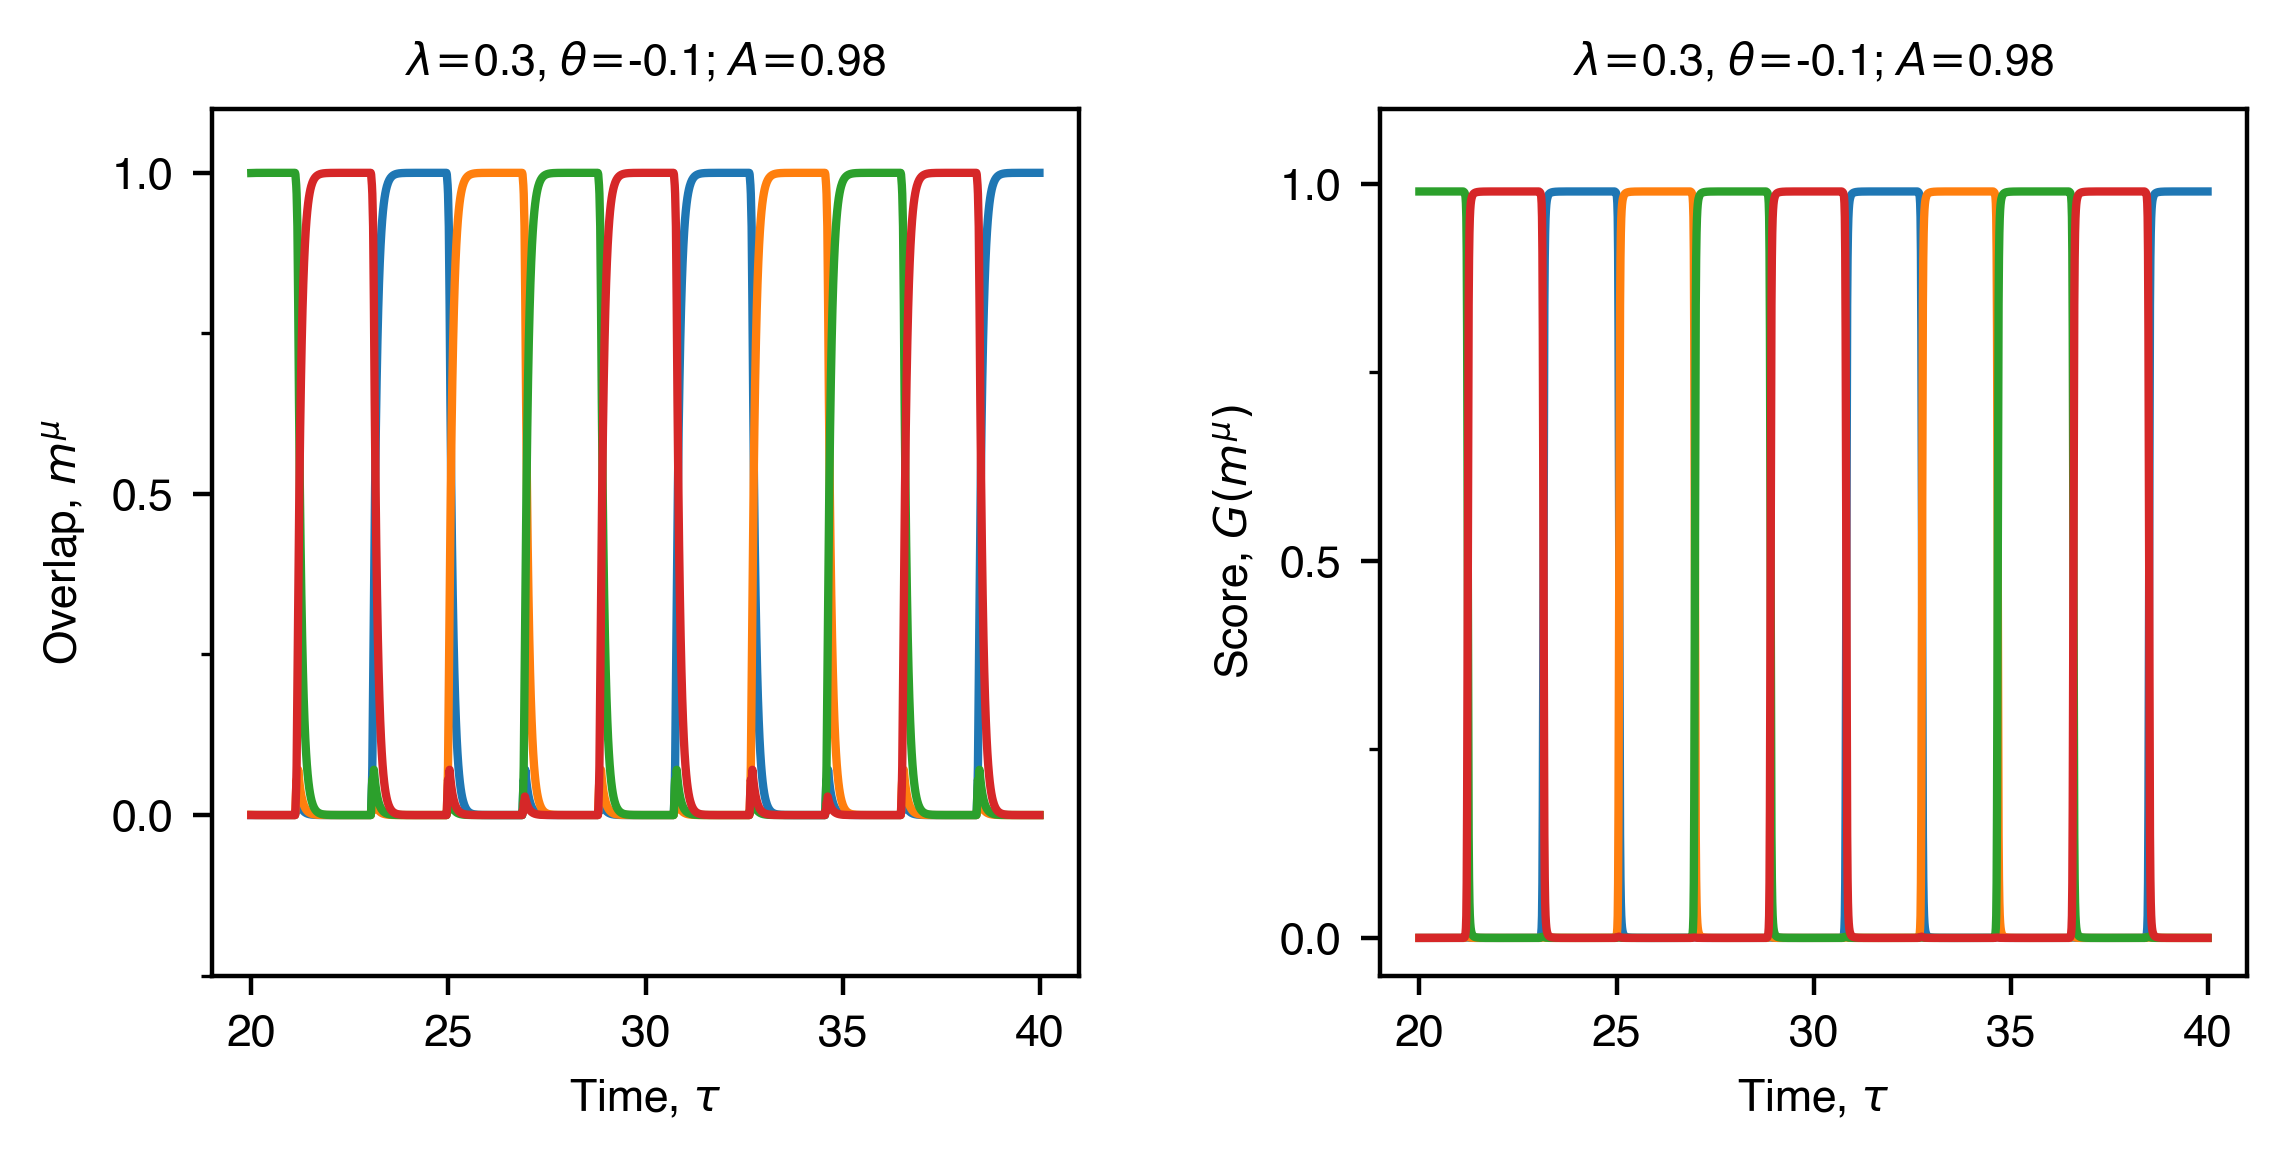

In [18]:
a = 2000
b = 4000

fig, ax = plt.subplots(1,2, figsize=(6,3), dpi=400, tight_layout=True)
 
ax[0].plot(ts[a:b]/tau, m[:,a:b].T);
ax[0].set_box_aspect(1)
ax[0].set_title(fr"$\lambda\!=\!${gamma}, $\theta\!=\!${thet}; $A\!=\!${score_arr[0]:.2f}", fontsize=8)
ax[0].set_yticks([-0.5, 0, 0.5, 1.0])
ax[0].set_yticks([-0.75, -0.25, 0.25, 0.75], minor=True)

ax[0].set_ylim(-0.25, 1.1)

ax[0].set_yticklabels(["-0.5", "0.0", "0.5", "1.0"])
ax[0].set_ylabel(fr"Overlap, $ m^\mu $", fontsize=8)
ax[0].set_xlabel(fr"Time, $\tau$", fontsize=8)
ax[0].tick_params(axis='both', which='major', labelsize=8)

ax[1].plot(ts[a:b]/tau, garr[:,a:b].T);
ax[1].set_box_aspect(1)

ax[1].set_ylim(-0.05, 1.1)
ax[1].set_title(fr"$\lambda\!=\!${gamma}, $\theta\!=\!${thet}; $A\!=\!${score_arr[0]:.2f}", fontsize=8)
ax[1].set_yticks([0, 0.5, 1.0])
ax[1].set_yticks([0.25, 0.75], minor=True)

ax[1].set_yticklabels(["0.0", "0.5", "1.0"])
ax[1].set_ylabel(fr"Score, $ G(m^\mu) $", fontsize=8)
ax[1].set_xlabel(fr"Time, $\tau$", fontsize=8)
ax[1].tick_params(axis='both', which='major', labelsize=8)

plt.subplots_adjust(wspace=0.05,hspace=0.05)

fig.align_ylabels(ax[0])

## Visualizing patterns

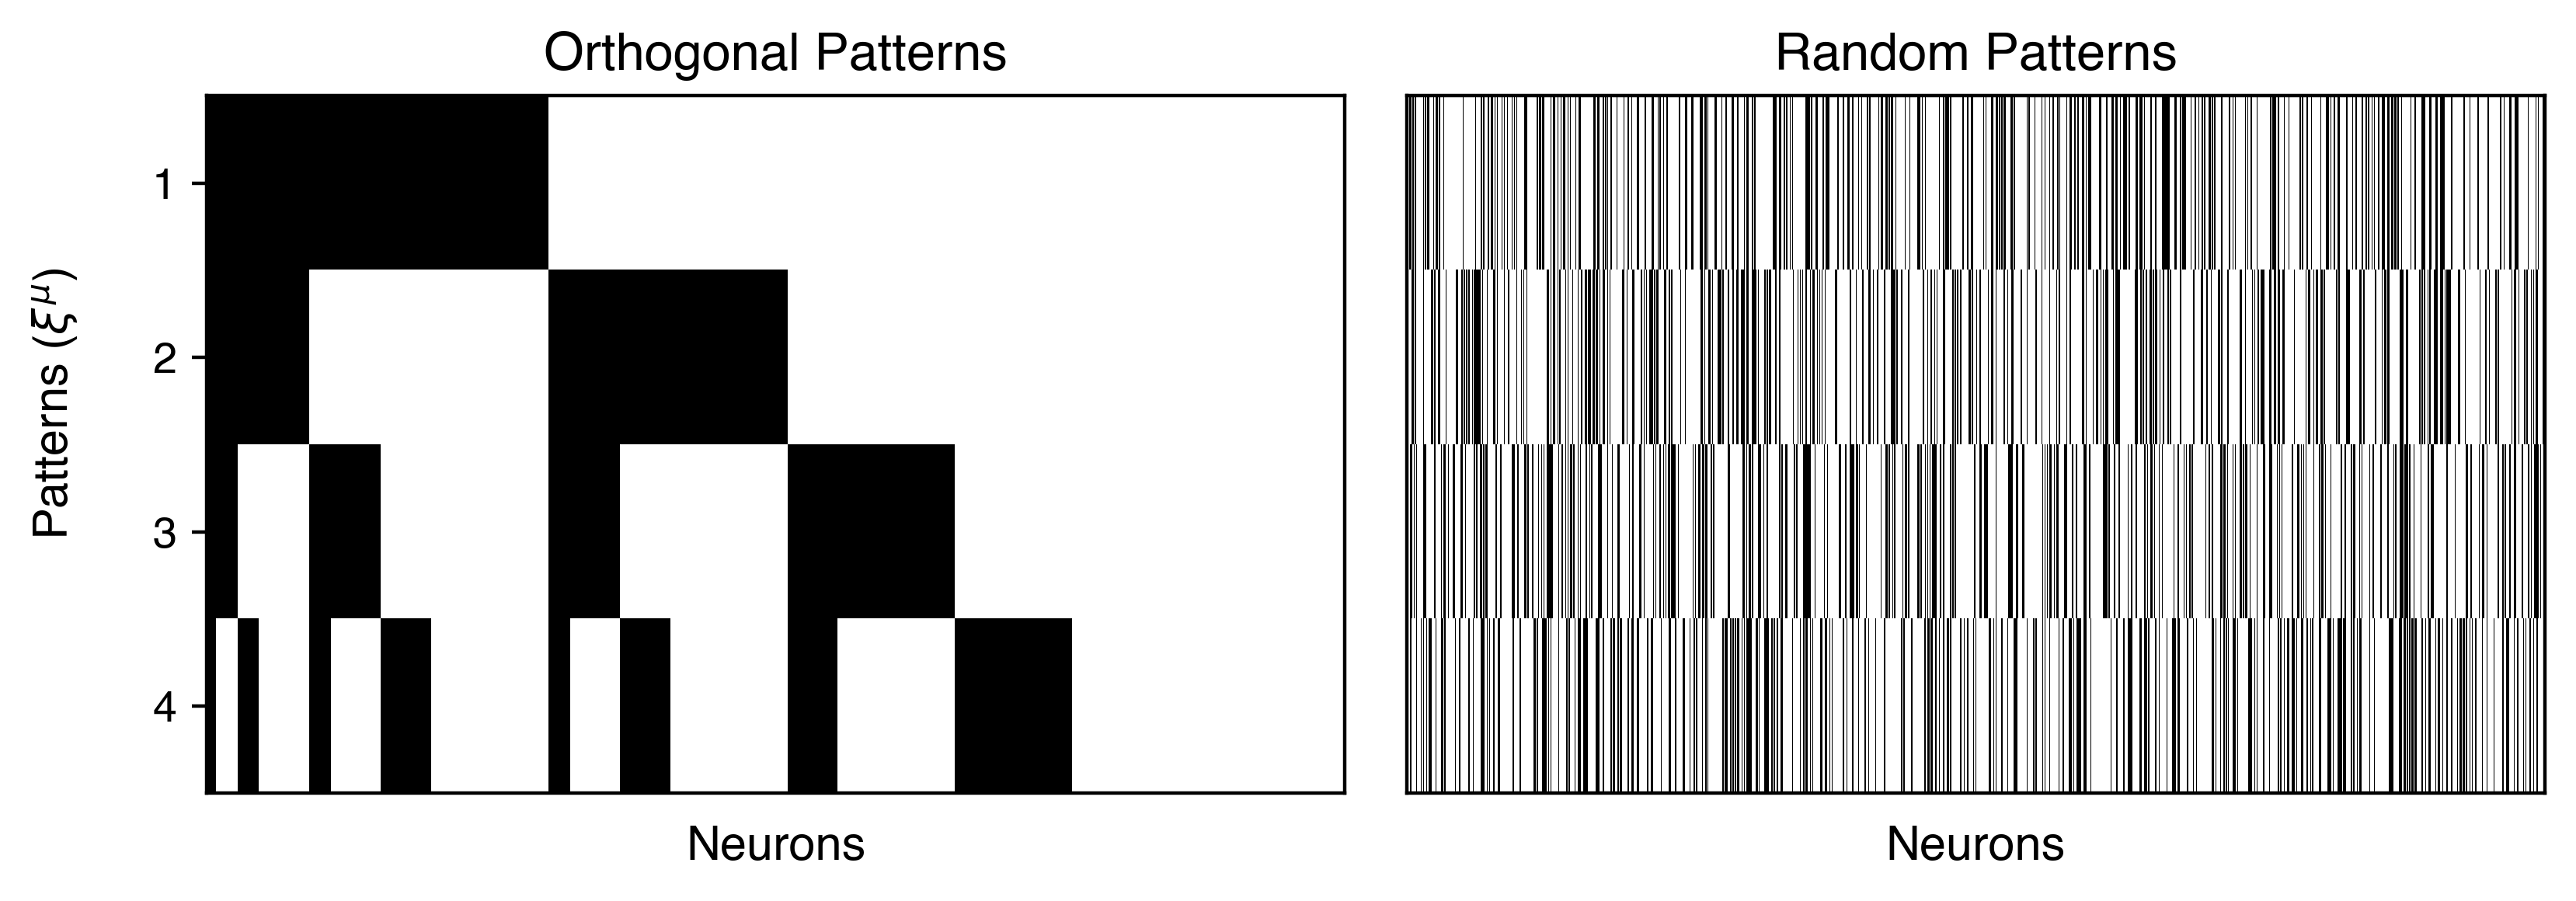

In [37]:
fig, ax = plt.subplots(1,2, figsize=(8,3), dpi=400, tight_layout=True)
patterns = generate_Q_intersection(n_p, n_s, param_dict["activities"])

ax[0].imshow(patterns, interpolation="None", aspect="auto", cmap='Greys')
ax[0].set_yticks([0,1,2,3])
ax[0].set_yticklabels([1,2,3,4])
ax[0].set_xticks([])

ax[0].set_xlabel(r"Neurons", size=11)
ax[0].set_ylabel(r"", size=11)
ax[0].set_title("Orthogonal Patterns")

patterns = random_patterns(n_p, n_s, param_dict["activities"])

ax[1].imshow(patterns, interpolation="None", aspect="auto", cmap='Greys')
ax[1].set_yticks([])
ax[1].set_yticklabels([])

ax[1].set_xticks([])
ax[1].set_xticklabels([])
ax[1].set_ylabel(r"", size=11)
ax[1].set_xlabel(r"Neurons", size=11)
ax[1].set_title("Random Patterns")

fig.text(-0.03, 0.55, r"Patterns ($\xi^\mu$)", va='center', rotation='vertical', size=11)
fig.subplots_adjust(wspace=1,hspace=1)

## Multiple simulations

In [20]:
param_dict_MSI_1 = {"net_type": "MSI",
              "activities": np.array([0.3]).repeat(n_p),
              "mbar0": 0.8,
              "gamma": 0.1,
              "theta": 0.06,
              "noise_scale": 0.00,
              "simulation_type": "sector"
             }

param_dict_MSI_2 = {"net_type": "MSI",
              "activities": np.array([0.3]).repeat(n_p),
              "mbar0": 0.8,
              "gamma": 0.25,
              "theta": 0.05,
              "noise_scale": 0.00,
              "simulation_type": "sector"
             }

param_dict_MSI_3 = {"net_type": "MSI",
              "activities": np.array([0.3]).repeat(n_p),
              "mbar0": 0.8,
              "gamma": 0.2,
              "theta": -0.02,
              "noise_scale": 0.00,
              "simulation_type": "sector"
             }

param_dict_MSI_4 = {"net_type": "MSI",
              "activities": np.array([0.3]).repeat(n_p),
              "mbar0": 0.8,
              "gamma": 0.3,
              "theta": -0.1,
              "noise_scale": 0.00,
              "simulation_type": "sector"
             }

results_dict = {}
list_of_params = [param_dict_MSI_1, param_dict_MSI_2, param_dict_MSI_3, param_dict_MSI_4]
labels = ["MSI_1", "MSI_2", "MSI_3", "MSI_4"]

n_p = 4
n_s = 1000 # placeholder
t_init = 0
t_end = 600
dt = 0.05
tau = 10
for idx, param_dict in enumerate(list_of_params):
    patterns = generate_Q_intersection(n_p, n_s, param_dict["activities"])
    sizes, sectors = get_sector_sizes(n_p, param_dict["activities"])
    
    ts, m, mbar, sa = SDE_solver(t_init, t_end, tau, dt, param_dict["noise_scale"], param_dict["gamma"], 
                                param_dict["theta"], param_dict["activities"], patterns, sectors, sizes, 
                                param_dict["net_type"], n_p, n_s, param_dict["mbar0"], param_dict["simulation_type"])
    results_dict[labels[idx]] = (ts, m, sa, param_dict["gamma"], param_dict["theta"])

/var/folders/m6/d33f9cts3cnglkrymdy1gxxh0000gn/T/ipykernel_10471/3192765734.py:28: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "generate_Q_intersection" failed type inference due to: Invalid use of type(CPUDispatcher(<function get_sector_sizes at 0x13fd84790>)) with parameters (int64, array(float64, 1d, C))

During: resolving callee type: type(CPUDispatcher(<function get_sector_sizes at 0x13fd84790>))
During: typing of call at /var/folders/m6/d33f9cts3cnglkrymdy1gxxh0000gn/T/ipykernel_10471/3192765734.py (32)


File "../../../var/folders/m6/d33f9cts3cnglkrymdy1gxxh0000gn/T/ipykernel_10471/3192765734.py", line 32:
<source missing, REPL/exec in use?>

  @jit
/var/folders/m6/d33f9cts3cnglkrymdy1gxxh0000gn/T/ipykernel_10471/3192765734.py:28: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "generate_Q_intersection" failed type inference due to: Cannot determine Numba type of <class

## Visualizing multiple simulations

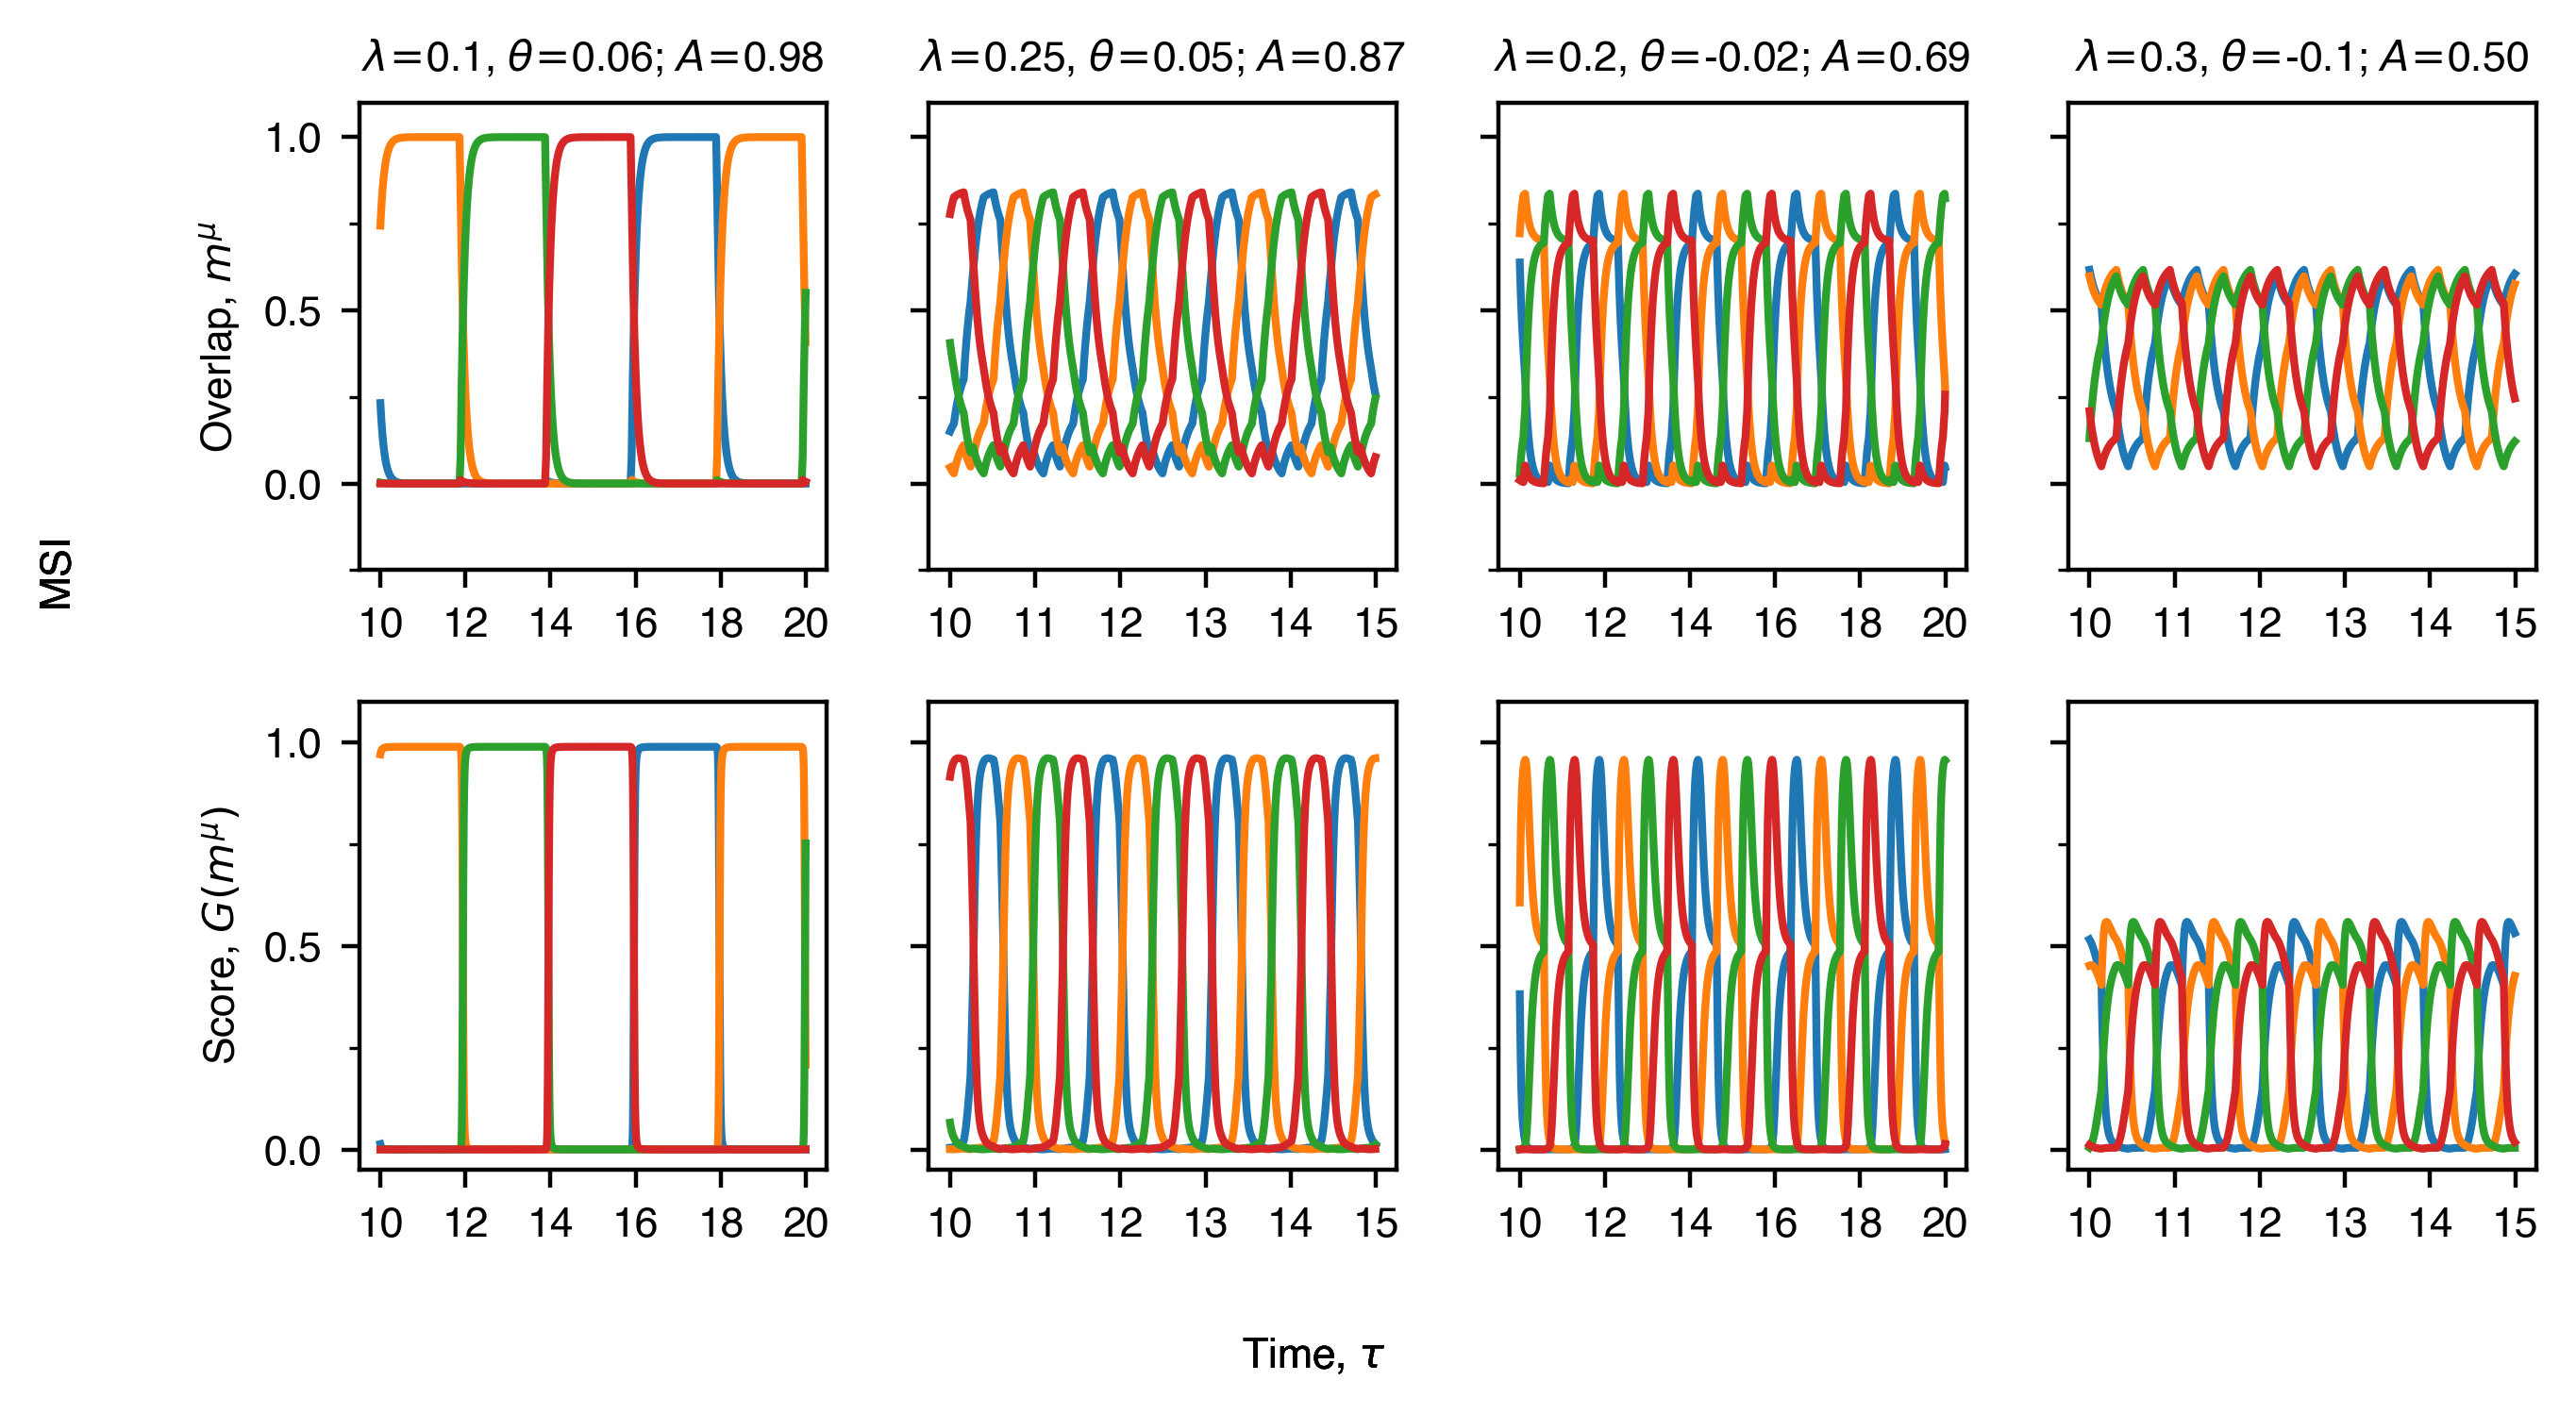

In [21]:
fig, ax = plt.subplots(2,4, figsize=(7,3.5), dpi=400, tight_layout=True)
net = "MSI"

ab = [(2000,4000),
     (2000,3000),
     (2000, 4000),
     (2000,3000)]

for idx in range(4):
    for (ts, m, sa, gamma, thet) in [results_dict[f"{net}_{idx+1}"]]:
        
        (a,b) = ab[idx]
        ax[0,idx].xaxis.set_major_locator(MaxNLocator(integer=True))
        ax[1,idx].xaxis.set_major_locator(MaxNLocator(integer=True))

        garr = g(m, beta=10, thresh=1-0.3) # begin scoring time series
        score_arr = []
        intervals = get_intervals(garr[:,a:b])
        scores = get_scores(intervals, garr[:,a:b])
        if scores:
            scores = np.array(scores, dtype=float)
            score_arr.append(np.mean(scores[:,1]))
        else:
            score_arr.append(np.nan) # end scoring time series

        ax[0,idx].plot(ts[a:b]/tau, m[:,a:b].T);
        ax[0,idx].set_box_aspect(1)
        ax[0,idx].set_title(fr"$\lambda\!=\!${gamma}, $\theta\!=\!${thet}; $A\!=\!${score_arr[0]:.2f}", fontsize=8)
        ax[0,idx].set_yticks([-0.5, 0, 0.5, 1.0])
        ax[0,idx].set_yticks([-0.75, -0.25, 0.25, 0.75], minor=True)

        ax[0,idx].set_ylim(-0.25, 1.1)
        if idx != 0:
            ax[0,idx].set_yticklabels([])
        else:
            ax[0,idx].set_yticklabels(["-0.5", "0.0", "0.5", "1.0"])
            ax[0,idx].set_ylabel(fr"Overlap, $ m^\mu $", fontsize=8)
        ax[0,idx].tick_params(axis='both', which='major', labelsize=8)



        ax[1,idx].plot(ts[a:b]/tau, garr[:,a:b].T);
        ax[1,idx].set_box_aspect(1)

        ax[1,idx].set_ylim(-0.05, 1.1)
        ax[1,idx].set_yticks([0, 0.5, 1.0])
        ax[1,idx].set_yticks([0.25, 0.75], minor=True)

        if idx != 0:
            ax[1,idx].set_yticklabels([])
        else:
            ax[1,idx].set_yticklabels(["0.0", "0.5", "1.0"])
            ax[1,idx].set_ylabel(fr"Score, $ G(m^\mu) $", fontsize=8)
        ax[1,idx].tick_params(axis='both', which='major', labelsize=8)

    fig.text(0.51, -0.05, fr'Time, $ \tau $', ha='center', fontsize=8, fontweight="ultralight")
    plt.subplots_adjust(wspace=0.05,hspace=0.05)

    ax[0,0].annotate(f"{net}", (-0.1, 0), xytext=(-45, 0), ha='right', va='center',
                    fontsize=8, rotation=90, xycoords='axes fraction',
                    textcoords='offset points', fontweight="ultralight", font="Helvetica")
    fig.align_ylabels(ax[0])

## Generating a phase diagram

In [33]:
n_s = 1000 # number of neurons
n_p = 4 # number of patterns
t_init = 0
t_end = 5000
dt = 0.1
tau = 10

param_dict = {"net_type": "SK",
              "activities": np.array([0.3]).repeat(n_p),
              "mbar0": 0.8, #initial mbar value
              "noise_scale": 0.00,
              "simulation_type": "neural"
             }

# computing patterns for neural simulations
patterns = generate_Q_intersection(n_p, n_s, param_dict["activities"])
sizes, sectors = get_sector_sizes(n_p, param_dict["activities"])

gamma_range = aspace(0,2,0.05)
theta_range = aspace(-1,1,0.05)
gv, tv = np.meshgrid(gamma_range, theta_range, indexing='ij')
phase_space = np.zeros_like(gv)
with tqdm(total = gv.size) as pbar:
    for i in range(len(gamma_range)):
        for j in range(len(theta_range)):

            gamma = gv[i,j]
            theta = tv[i,j]
            ts, m, mbar, _ = SDE_solver(t_init, t_end, tau, dt, param_dict["noise_scale"], gamma, 
                                theta, param_dict["activities"], patterns, sectors, sizes, 
                                param_dict["net_type"], n_p, n_s, param_dict["mbar0"], param_dict["simulation_type"])

            garr = g(m, beta=10, thresh=1-0.3)
            score_arr = []
            b = m.shape[1]
            a = b//2
            intervals = get_intervals(garr[:,a:b])
            scores = get_scores(intervals, garr[:,a:b])
            if scores:
                scores = np.array(scores, dtype=float)
                score_arr.append(np.mean(scores[:,1]))
            else:
                score_arr.append(np.nan)
            phase_space[i,j] = score_arr[0] # the phase diagram consists of average retrieval accuracy over a trajectory
            pbar.update()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1681/1681 [40:09<00:00,  1.43s/it]


## Visualizing phase diagram

Text(0.5, 1.0, 'Phase space')

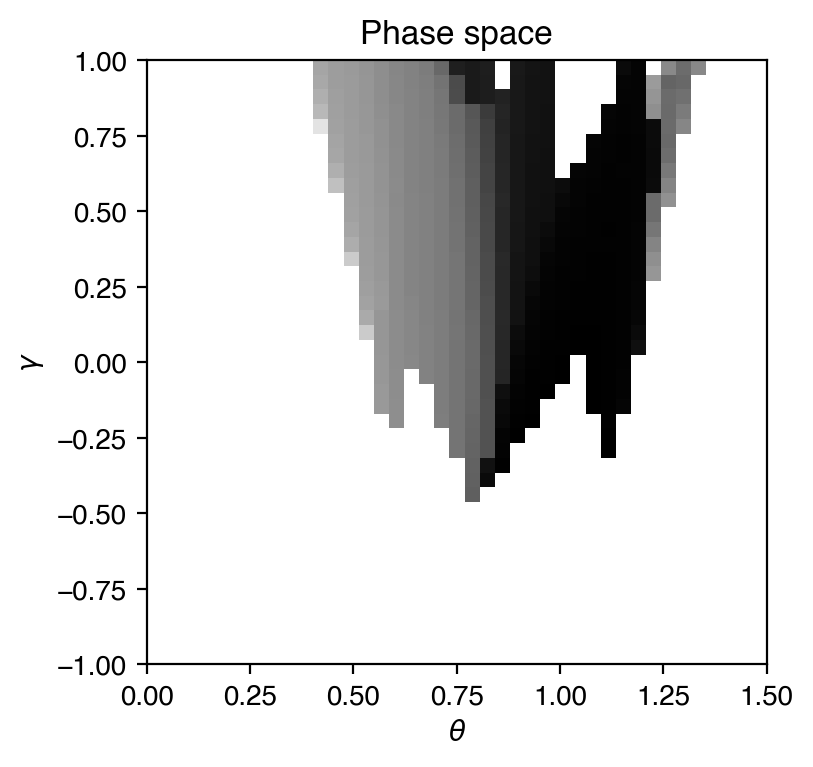

In [35]:
fig = plt.figure(dpi=200, figsize=(4,4));

plt.imshow(phase_space, aspect="auto", extent=extent, 
        alpha=1, vmin=0, cmap='Greys', origin="lower", interpolation="None")
plt.xlabel(r"$\theta$")
plt.ylabel(r"$\gamma$")
plt.title("Phase space")